## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

https://www.informatik.uni-leipzig.de/~saeedi/musicBrainz_readme.txt

```
5 sources
---------- 
TID: a unique record's id (in the complete dataset).
CID: cluster id (records having the same CID are duplicate)
CTID: a unique id within a cluster (if two records belong to the same cluster they will have the same CID but different CTIDs). These ids (CTID) start with 1 and grow until cluster size.
SourceID: identifies to which source a record belongs (there are five sources). The sources are deduplicated.
Id: the original id from the source. Each source has its own Id-Format. Uniqueness is not guaranteed!! (can be ignored).
number: track or song number in the album.
length: the length of the track.
artist: the interpreter (artist or band) of the track.
year: date of publication.
language: language of the track.
```

In [6]:
import glob
import csv
from tqdm.auto import tqdm

current_row_id = 0
row_dict = {}
rows_total = 19375
clusters_total = 10000
cluster_attr = 'CID'

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/musicbrainz-20-A01.csv.dapo') as f:
        for row in csv.DictReader(f):
            row['id'] = current_row_id
            row[cluster_attr] = int(row[cluster_attr])  # convert cluster_attr to int
            row_dict[current_row_id] = row
            current_row_id += 1
            pbar.update(1)

In [7]:
row_dict[1]

{'TID': '2',
 'CID': 2512,
 'CTID': '5',
 'SourceID': '4',
 'id': 1,
 'number': '7',
 'title': '007',
 'length': '1m 58sec',
 'artist': '[unknown]',
 'album': 'Cantigas de roda (unknown)',
 'year': 'null',
 'language': 'Por.'}

## Preprocess

In [8]:
attr_list = ['title', 'artist', 'album']

In [9]:
import unidecode
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    return ' '.join(s_part[:30] for s_part in default_tokenizer(s))[:100]

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [10]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [11]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [12]:
attr_info_dict = {
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'artist': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'album': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [13]:
from entity_embed import build_row_numericalizer

row_numericalizer = build_row_numericalizer(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

15:47:14 INFO:For attr='title', computing actual alphabet and max_str_len
15:47:14 INFO:For attr='title', using actual_max_str_len=30
15:47:14 INFO:For attr='artist', computing actual alphabet and max_str_len
15:47:14 INFO:For attr='artist', using actual_max_str_len=30
15:47:14 INFO:For attr='album', computing actual alphabet and max_str_len
15:47:14 INFO:For attr='album', using actual_max_str_len=30


{'title': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7f7b6f79eaf0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=30, vocab=None),
 'artist': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer=<function default_tokenizer at 0x7f7b6f79eaf0>, alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}',

In [14]:
from entity_embed import DeduplicationDataModule

train_cluster_len = 1500
valid_cluster_len = 2500
datamodule = DeduplicationDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=50,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    random_seed=random_seed
)

## Training

In [15]:
from entity_embed import EntityEmbed

ann_k = 10
model = EntityEmbed(
    datamodule,
    ann_k=ann_k,
    use_mask=False
)

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 50
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.5',
   min_delta=0.00,
   patience=10,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'music'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

15:47:15 INFO:GPU available: True, used: True
15:47:15 INFO:TPU available: None, using: 0 TPU cores
15:47:15 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
trainer.fit(model, datamodule)

15:47:15 INFO:Train pair count: 4883
15:47:15 INFO:Valid pair count: 8092
15:47:15 INFO:Test pair count: 3275
15:47:17 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 3.4 M 
1 | losser      | SupConLoss | 0     
-------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params


1

In [18]:
model.blocker_net.get_signature_weights()

{'title': 0.394785076379776,
 'artist': 0.2892424166202545,
 'album': 0.3159724771976471}

## Testing

In [19]:
trainer.test(ckpt_path='best')

15:51:19 INFO:Train pair count: 4883
15:51:19 INFO:Valid pair count: 8092
15:51:19 INFO:Test pair count: 3275



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_f1_at_0.3': 0.3185265438786566,
 'test_f1_at_0.5': 0.8389797253106607,
 'test_f1_at_0.7': 0.9652268828941214,
 'test_f1_at_0.9': 0.7266718506998444,
 'test_pair_entity_ratio_at_0.3': 5.897160664819944,
 'test_pair_entity_ratio_at_0.5': 1.513157894736842,
 'test_pair_entity_ratio_at_0.7': 1.0865650969529086,
 'test_pair_entity_ratio_at_0.9': 0.6471606648199446,
 'test_precision_at_0.3': 0.18988902589395806,
 'test_precision_at_0.5': 0.7338672768878719,
 'test_precision_at_0.7': 0.9862970044614404,
 'test_precision_at_0.9': 1.0,
 'test_recall_at_0.3': 0.9874809160305343,
 'test_recall_at_0.5': 0.979236641221374,
 'test_recall_at_0.7': 0.9450381679389313,
 'test_recall_at_0.9': 0.5706870229007633}
--------------------------------------------------------------------------------


[{'test_precision_at_0.3': 0.18988902589395806,
  'test_recall_at_0.3': 0.9874809160305343,
  'test_f1_at_0.3': 0.3185265438786566,
  'test_pair_entity_ratio_at_0.3': 5.897160664819944,
  'test_precision_at_0.5': 0.7338672768878719,
  'test_recall_at_0.5': 0.979236641221374,
  'test_f1_at_0.5': 0.8389797253106607,
  'test_pair_entity_ratio_at_0.5': 1.513157894736842,
  'test_precision_at_0.7': 0.9862970044614404,
  'test_recall_at_0.7': 0.9450381679389313,
  'test_f1_at_0.7': 0.9652268828941214,
  'test_pair_entity_ratio_at_0.7': 1.0865650969529086,
  'test_precision_at_0.9': 1.0,
  'test_recall_at_0.9': 0.5706870229007633,
  'test_f1_at_0.9': 0.7266718506998444,
  'test_pair_entity_ratio_at_0.9': 0.6471606648199446}]

In [20]:
import gc
del trainer
gc.collect()

15

## Testing manually 

In [21]:
# Only call this if test above wasn't run
# datamodule.setup(stage='test')

In [22]:
test_row_dict = datamodule.test_row_dict
test_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=16
)

In [23]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [24]:
import gc
del model
del datamodule
gc.collect()

4696

In [25]:
assert len(test_vector_dict) == len(test_row_dict)

In [26]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

CPU times: user 731 ms, sys: 4.53 ms, total: 735 ms
Wall time: 114 ms


In [27]:
%%time

sim_threshold = 0.5
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold
)

CPU times: user 957 ms, sys: 4.2 ms, total: 961 ms
Wall time: 90.3 ms


In [28]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

1.513157894736842

In [29]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.7338672768878719, 0.979236641221374)

In [30]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

1163

In [31]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

68

In [32]:
cos_similarity = lambda a, b: np.dot(a, b)

In [33]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.34919807,
 {'TID': '4914',
  'CID': 8662,
  'CTID': '2',
  'SourceID': '4',
  'id': 4913,
  'number': '14',
  'title': '014 - suite andalucia : gitanerias',
  'length': '1m 58sec',
  'artist': 'frank flynn emilio',
  'album': 'tribute to ernesto lecuona ( 1997 )',
  'year': 'null',
  'language': 'pa.'},
 {'TID': '16840',
  'CID': 8662,
  'CTID': '1',
  'SourceID': '3',
  'id': 16839,
  'number': 'Suite Andalucia: Gitanerias - Tribute to Ernesto Lecuona',
  'title': '14',
  'length': '1.974',
  'artist': 'frank emilio flynn',
  'album': '',
  'year': "'97",
  'language': 'Spanish'})

(0.40841103,
 {'TID': '5078',
  'CID': 1154,
  'CTID': '4',
  'SourceID': '4',
  'id': 5077,
  'number': '20',
  'title': '020 - space jerk',
  'length': '0m 29sec',
  'artist': 'kevin jarvis',
  'album': 'promos 5 : kidz stuff ( unknown )',
  'year': 'null',
  'language': 'EEng.'},
 {'TID': '14346',
  'CID': 1154,
  'CTID': '3',
  'SourceID': '3',
  'id': 14345,
  'number': '20',
  'title': 'nulll',
  'length': '0.483',
  'artist': 'evin jarvis',
  'album': '',
  'year': '',
  'language': 'English'})

(0.2848588,
 {'TID': '3422',
  'CID': 8904,
  'CTID': '3',
  'SourceID': '2',
  'id': 3421,
  'number': '1',
  'title': 'null',
  'length': '364',
  'artist': '',
  'album': 'untitled 2 / bad brother',
  'year': '05',
  'language': 'English'},
 {'TID': '12727',
  'CID': 8904,
  'CTID': '4',
  'SourceID': '3',
  'id': 12726,
  'number': '1',
  'title': 'untitled 2 - untitled 2 / bad brother',
  'length': '6.067',
  'artist': 'phrenetic',
  'album': '',
  'year': "'05",
  'language': 'English'})

(0.02522973,
 {'TID': '15081',
  'CID': 5099,
  'CTID': '5',
  'SourceID': '1',
  'id': 15080,
  'number': '011',
  'title': "i ' ve never been to me ( hits of the 80s : the ultimate collection )",
  'length': '04:00',
  'artist': 'chrlene',
  'album': 'hits of the 80s : the ultimate collection',
  'year': '2006',
  'language': ''},
 {'TID': '17910',
  'CID': 5099,
  'CTID': '4',
  'SourceID': '5',
  'id': 17909,
  'number': '5612990',
  'title': '11',
  'length': "I've Never Been to Me",
  'artist': '240440',
  'album': 'charlene',
  'year': 'Hits of the 80s: The Ultimate Collection',
  'language': '2006'})

(0.13371703,
 {'TID': '2905',
  'CID': 2371,
  'CTID': '2',
  'SourceID': '3',
  'id': 2904,
  'number': '6',
  'title': 'unnown',
  'length': '4.4',
  'artist': 'sorg uten tarer',
  'album': '',
  'year': "'07",
  'language': 'English'},
 {'TID': '9261',
  'CID': 2371,
  'CTID': '3',
  'SourceID': '4',
  'id': 9260,
  'number': '6',
  'title': '006 - moonkissed eyes',
  'length': '4m 24sec',
  'artist': 'sorg uten tarer',
  'album': 'moonsilver ( 2007 )',
  'year': 'null',
  'language': 'Eng.'})

(0.45521355,
 {'TID': '8494',
  'CID': 4390,
  'CTID': '1',
  'SourceID': '1',
  'id': 8493,
  'number': '9',
  'title': 'one ton ( volunteered slavery )',
  'length': '05:01',
  'artist': 'rahsaan roland kirk',
  'album': 'volunteered slavery',
  'year': '2005',
  'language': ''},
 {'TID': '19331',
  'CID': 4390,
  'CTID': '2',
  'SourceID': '2',
  'id': 19330,
  'number': '7',
  'title': 'rahsaan roland kirk - one ton',
  'length': '301',
  'artist': '',
  'album': 'unknown',
  'year': '05',
  'language': 'English'})

(0.23976602,
 {'TID': '2208',
  'CID': 1154,
  'CTID': '1',
  'SourceID': '1',
  'id': 2207,
  'number': '020',
  'title': 'space jerk ( promos 5 : kidz stuff )',
  'length': '00:29',
  'artist': 'kevin jarvis',
  'album': 'promos 5 : kidz stuff',
  'year': '',
  'language': ''},
 {'TID': '14346',
  'CID': 1154,
  'CTID': '3',
  'SourceID': '3',
  'id': 14345,
  'number': '20',
  'title': 'nulll',
  'length': '0.483',
  'artist': 'evin jarvis',
  'album': '',
  'year': '',
  'language': 'English'})

(0.38985124,
 {'TID': '2965',
  'CID': 1544,
  'CTID': '1',
  'SourceID': '2',
  'id': 2964,
  'number': '8',
  'title': 'darryl way - juliet',
  'length': '247',
  'artist': '',
  'album': 'under the soft',
  'year': '91',
  'language': 'English'},
 {'TID': '18300',
  'CID': 1544,
  'CTID': '2',
  'SourceID': '3',
  'id': 18299,
  'number': '8',
  'title': '8',
  'length': '4.117',
  'artist': 'darryl way',
  'album': '',
  'year': "'91",
  'language': 'English'})

(0.37148783,
 {'TID': '9364',
  'CID': 901,
  'CTID': '2',
  'SourceID': '2',
  'id': 9363,
  'number': 'A5',
  'title': 'du bian man li nai - marinanoxia',
  'length': 'null',
  'artist': '',
  'album': "oniyanzi sailing meng gong chang ' 87 live",
  'year': '87',
  'language': 'Japanese'},
 {'TID': '16923',
  'CID': 901,
  'CTID': '4',
  'SourceID': '4',
  'id': 16922,
  'number': 'A5',
  'title': '0a5 -',
  'length': 'unknown',
  'artist': '',
  'album': 'sailin 87 live ( 1987 )',
  'year': 'null',
  'language': 'Jap.'})

(0.16005486,
 {'TID': '895',
  'CID': 2198,
  'CTID': '2',
  'SourceID': '3',
  'id': 894,
  'number': '4',
  'title': 'the cn tower belongs to the dead ( many ives version ) - many lives - 49 mp',
  'length': '5.467',
  'artist': 'final fantasy',
  'album': '',
  'year': "'06",
  'language': 'English'},
 {'TID': '4240',
  'CID': 2198,
  'CTID': '1',
  'SourceID': '2',
  'id': 4239,
  'number': '4',
  'title': 'n . a .',
  'length': '328',
  'artist': '',
  'album': 'many lives - 49 mp',
  'year': '06',
  'language': 'English'})

## t-sne visualization

In [34]:
vis_sample_size = 10

In [35]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [36]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [37]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

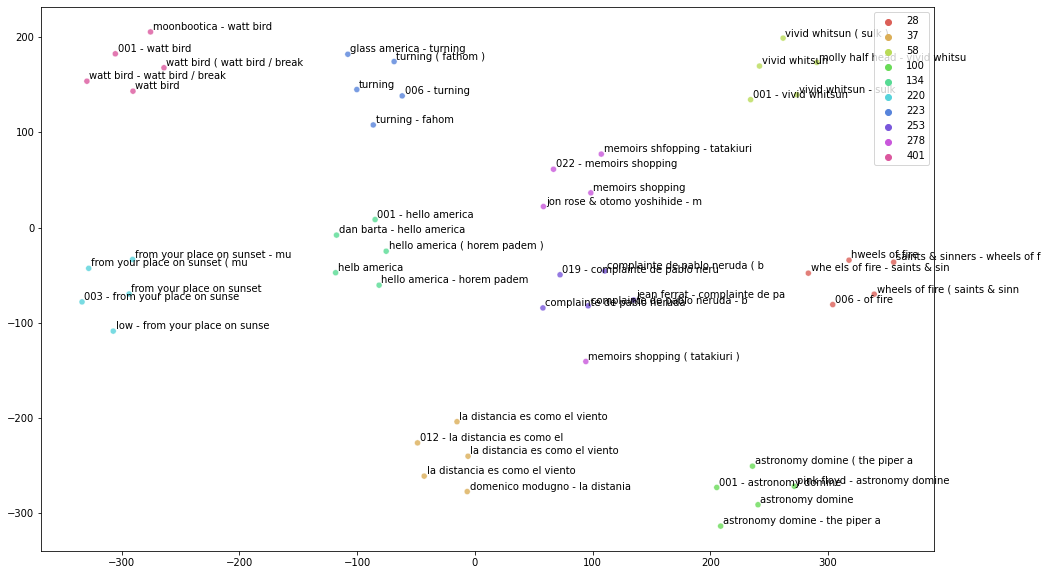

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)